In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "64" 

In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u


In [6]:
nside = 2048
lmax = 2048
 

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb=False 

In [11]:
datadir='/global/cscratch1/sd/giuspugl/workstation/FG_extension/extending_gnilc_dust/'



# Setting the inputs 

## Dust maps 
- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [12]:
dust_varresI = datadir+"COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"

dust_varresP= datadir+"COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [13]:
m_planck_varres ,h = hp.read_map(dust_varresP , [c+"_STOKES" for c in comp], h=True)
I_planck_varres ,h = hp.read_map(dust_varresI , h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [14]:
m_planck_varres <<= u.K_CMB 
I_planck_varres <<= (u. MJy/u.sr ) 
m_planck_varres = m_planck_varres.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))
I_planck_varres = I_planck_varres.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz)) 

then we are ready to combine both maps into one single TQU map. 

In [15]:
m_planck_varres[0] = I_planck_varres.copy() 


### GAL080 Planck  mask 

we mask the galaxy to estimate the power spectra with Namaster before and after small scale injection. 


masking 0.7912631829579672 of the sky


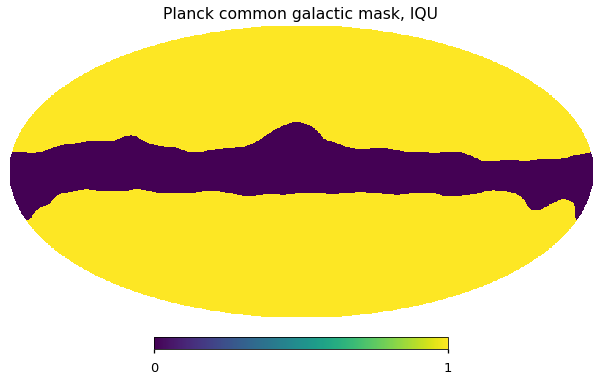

In [16]:
planck_mask =  hp.read_map(datadir+ "HFI_Mask_GalPlane-apo2deg_2048_R2.00_GAL080.fits")

planck_mask= np.int_( np.ma.masked_not_equal(planck_mask ,  0. ).mask )
fsky= planck_mask.sum()/planck_mask.size 
print(f"masking {fsky} of the sky" )  
hp.mollview(   planck_mask  , title=f"Planck common galactic mask, {comp}")


#### Monopole subtraction 


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [17]:
planck2018_monopole = (0.13*u.MJy/u.sr).to(u.uK_RJ, equivalencies=u.cmb_equivalencies(353*u.GHz) ) 

m_planck_varres[0][planck_mask]  -= planck2018_monopole 



We estimate how many pixels have I< P after we subtract the monopole 

In [18]:
maskmono =m_planck_varres [0]**2 < m_planck_varres[1]**2+m_planck_varres[2]**2
print(f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps ")

5 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


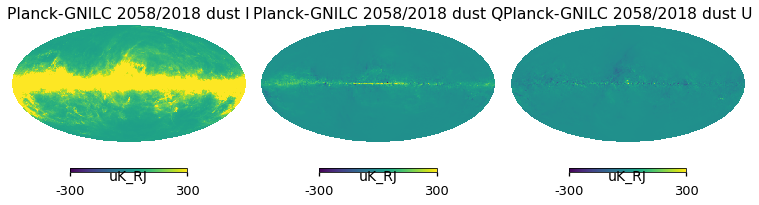

In [19]:
for i_pol, pol in components:
    hp.mollview(m_planck_varres[i_pol], title="Planck-GNILC 2058/2018 dust "+pol , sub=131+i_pol  , unit=m_planck_varres.unit, min=-300, max=300)
    
    

In [20]:
if not os.path.exists(datadir+'dust_gnilc_varres_no_monopole.fits') : 
    
    hp.write_map(datadir+"dust_gnilc_varres_no_monopole.fits", m_planck_varres   )

## Transform maps to Poltens quantities 

In [21]:
import numpy as np
import healpy as hp



def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i =np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))


In [22]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres .value)

<ipython-input-21-22da87ac96b7>:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
<ipython-input-21-22da87ac96b7>:10: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


check the transformation back and forth 

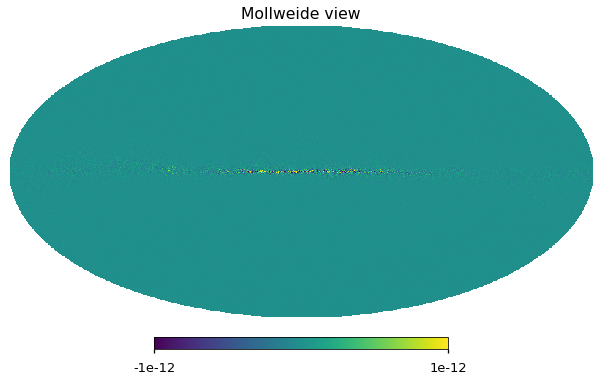

In [23]:
m_back   = log_pol_tens_to_map(log_pol_tens_varres ) 
hp.mollview( (m_planck_varres.value  - m_back )[1], min=-1e-12,max=1e-12 )
del m_back 

Checking NaNs  on the Poltens map 

In [24]:
print(f"{np.isnan(log_pol_tens_varres[0]).sum()  } pixels out of { maskmono.size} are NaNs in Log Pol Tens maps ")

5 pixels out of 50331648 are NaNs in Log Pol Tens maps 


In [25]:
for i in range(3):
    log_pol_tens_varres [i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(log_pol_tens_varres[i])

Set all the NaNs to the map median value  


In [26]:
assert np.isnan(log_pol_tens_varres).sum() == 0

In [27]:
if not os.path.exists(datadir+"dust_gnilc_logpoltens_varres_nomono.fits") : 
    hp.write_map(datadir+"dust_gnilc_logpoltens_varres_nomono.fits", log_pol_tens_varres)

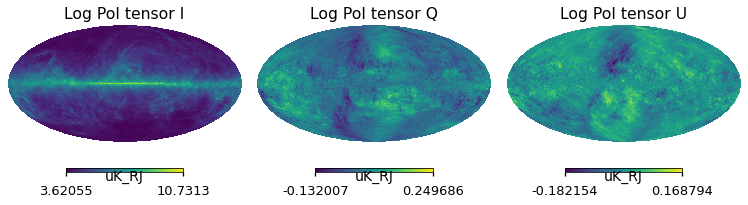

In [28]:
for i_pol, pol in components:
    hp.mollview(log_pol_tens_varres[i_pol], title="Log Pol tensor "+pol , sub=131+i_pol  , unit= m_planck_varres.unit)

In [29]:
from scipy.optimize import curve_fit

In [30]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [31]:
def run_anafast(m, lmax) : 
    clanaf=hp.anafast(m , lmax=lmax ) 
    cl ={} 
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2 ]
    ell = np.arange(lmax +1 ) 
    
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell,cl_norm, cl     



def run_namaster(m, mask, lmax):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=1, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0] ])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [32]:
print ("run anafast on masked sky  ")
ell,cl_norm,cl=run_anafast(log_pol_tens_varres,lmax)    

run anafast on masked sky  


## Fitting the power law from the fullsky power spectra 

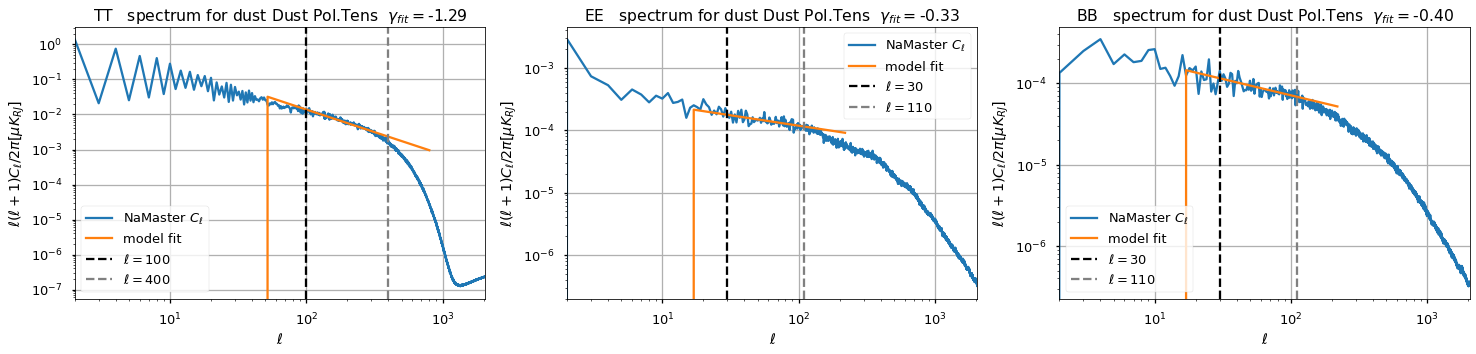

In [33]:
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell$")
    #plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl1[pol] , label="Anafast $C_\ell$")
    # plt.semilogx(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell smoothed$")
    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_sigma_G[pol], label="SS $C_\ell$")

    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="model fit")
    
    #plt.plot(w_ell**2,  label=f"Beam {c} $C_\ell$")

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    #plt.ylim(1, 30);
    #plt.xlim(ell_fit_low[pol]//2, lmax)
    #plt.ylim(0, 1e1 if pol == "TT" else 1e-3)


### Define Modulation maps 
as the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  

#### Modulation for  polarization : 
- smooth `i` map to 5 deg 
- we saturate all the pixels >4.5 to 1.1 
- reduce the dynamic range to range from .1 to 1.1 with MinMax rescaling  

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >4.5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [37]:
ismooth= hp.smoothing (log_pol_tens_varres[0] , fwhm=np.radians(5),lmax=lmax )


In [38]:
b1=1.1
b2=2
a=.1
minmax= lambda m,a,b: a + (b-a) * (m - m .min()  )/(m .max() -m .min () )

modulate_amp_pol= (ismooth )*1. 
modulate_amp= (ismooth )*1. 
val=4.5
mskmd= ismooth >val 
modulate_amp_pol[mskmd]= b1

modulate_amp_pol[~mskmd] =minmax(ismooth[~mskmd]  , a=a, b=b1)

modulate_amp[mskmd]=minmax(ismooth[mskmd] , a=b1, b=b2)

modulate_amp[~mskmd]=minmax(ismooth[~mskmd] , a=a, b=b1)  



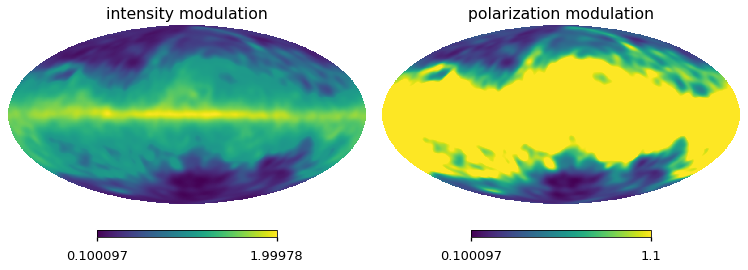

In [40]:
hp.mollview(modulate_amp, title='intensity modulation', sub=121)
hp.mollview(modulate_amp_pol, title='polarization modulation', sub=122)


### Making maps with small scales 
1. generate the Cl  from the fit power spectra and with the sigmoid high-pass filter 
2. construct Alm  from the Cl 
3. Filter Alm encoding  small scales with the  sigmoid 
4. Estimate Alm of the fullsky poltens maps encoding large scales  with the sigmoid low-pass filter ,  
5. Estimate maps from the Alm with large and small scales , `ls` and `ss` 
6. modulate small scales with modulation maps , i.e. `ss' =ss * modulation_maps` 
7. define new poltens maps as : `iqu = ls +ss'` 
8.  transform back to real `IQU` maps 

In [43]:
np.random.seed(777)
small_scales_input_cl = [
    1 \
    * model(ell, A_fit[pol], gamma_fit[pol]) \
    * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/10)  \
    / cl_norm \
    for pol in spectra_components
]
alm_log_pol_tens_fullsky = hp.map2alm(log_pol_tens_varres   , lmax=lmax, use_pixel_weights=True)
ii_SS_alm=np.empty_like(alm_log_pol_tens_fullsky)
ii_LS_alm=np.empty_like(alm_log_pol_tens_fullsky)
alm_ss =hp.synalm(small_scales_input_cl+ [np. zeros_like(small_scales_input_cl[0])]*3 ,lmax=lmax, new=True )
for ii, pol in enumerate(spectra_components ):
    
    sig_func =  sigmoid(ell, x0= ell_fit_high[pol], width= ell_fit_high[pol]/10)
    
    ii_SS_alm[ii] = hp.almxfl(alm_ss [ii] , (sig_func)**.2)
    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii] , (1.-sig_func)**.2 ) 

log_ss =hp.alm2map(ii_SS_alm , nside=nside ) 
log_ss[0] *=modulate_amp 
log_ss[1:] *=modulate_amp_pol

log_ls =hp.alm2map(ii_LS_alm, nside=nside ) 
ii_map_out = log_ss + log_ls 


<ipython-input-30-e2b761b15d12>:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [44]:
output_map = log_pol_tens_to_map(ii_map_out )

if not os.path.exists(datadir+"dust_gnilc_hybrid_out.fits") : 
    hp.write_map(datadir+'dust_gnilc_hybrid_out.fits', output_map,overwrite=True )

#### Plot maps 

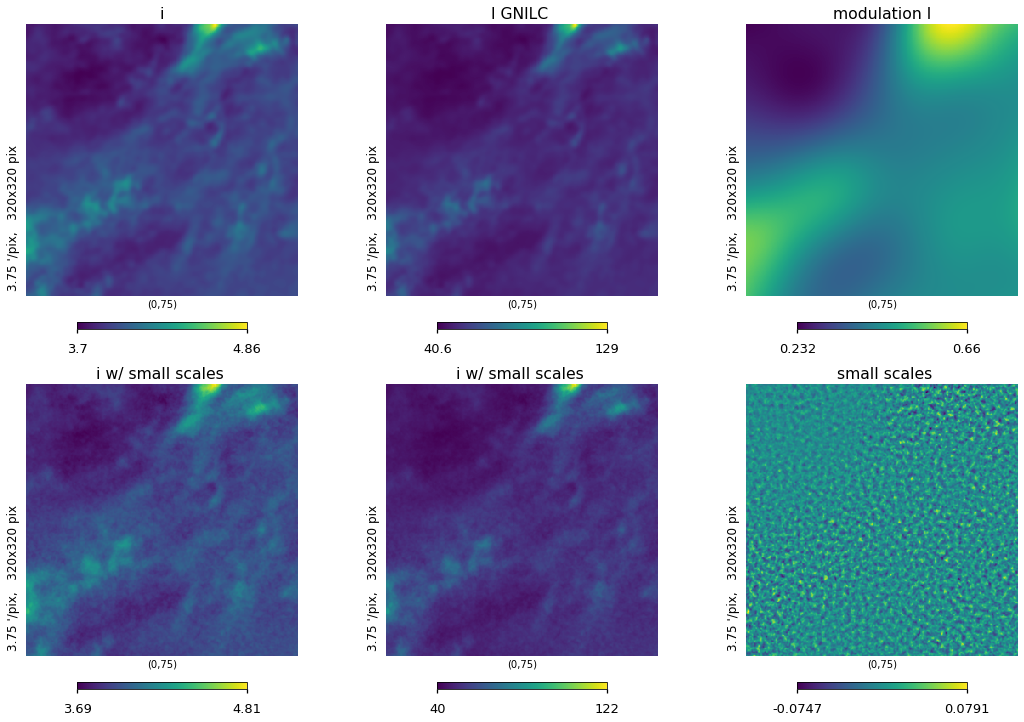

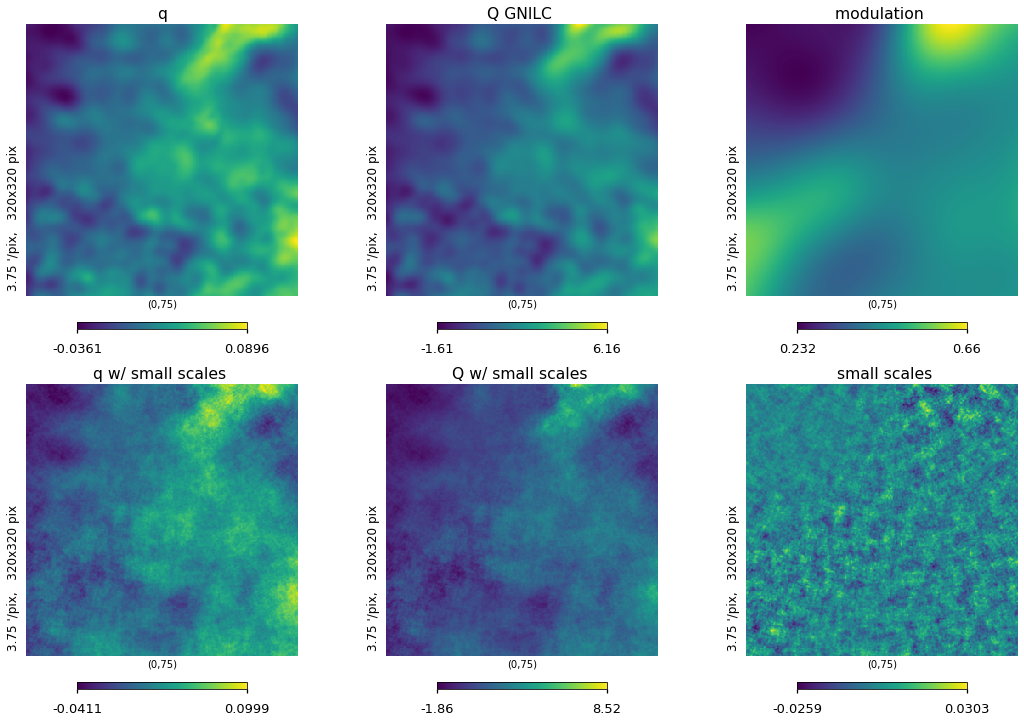

In [45]:
lat=75
plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[0] ,  title='i w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(log_pol_tens_varres [0],  title='i', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp),  title=' modulation I ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((m_planck_varres [0]),  title=' I GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[0],  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[0] ,  title='i w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )

lat=75
plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[1] ,  title='q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(log_pol_tens_varres [1],  title='q', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp_pol),  title=' modulation  ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((m_planck_varres [1]),  title=' Q GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[1],  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[1] ,  title='Q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )



In [46]:

fspectra=datadir+"dust_gnilc_hybrid_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    cl_in  ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
elif namaster_on_nb : 
    print("run Namaster  ")
    ell,cl_norm,cl_in = run_namaster(m_planck_varres, mask=planck_mask , lmax=lmax )
else : 
    print ("run anafast on masked sky  ")
    ell,cl_norm,cl_in=run_anafast(m_planck_varres *planck_mask ,lmax)   

read Namaster spectra  


In [47]:

fspectra=datadir+"dust_gnilc_hybrid_out_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    cl_out={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
elif namaster_on_nb : 
    print("run Namaster  ")
    ell,cl_norm,cl_out = run_namaster(output_map, mask=planck_mask , lmax=lmax )
else : 
    print ("run anafast on masked sky  ")
    ell,cl_norm,cl_out=run_anafast(output_map*planck_mask ,lmax)    

read Namaster spectra  


## Validate outputs estimating NaMaster power spectra on both input and outputs 

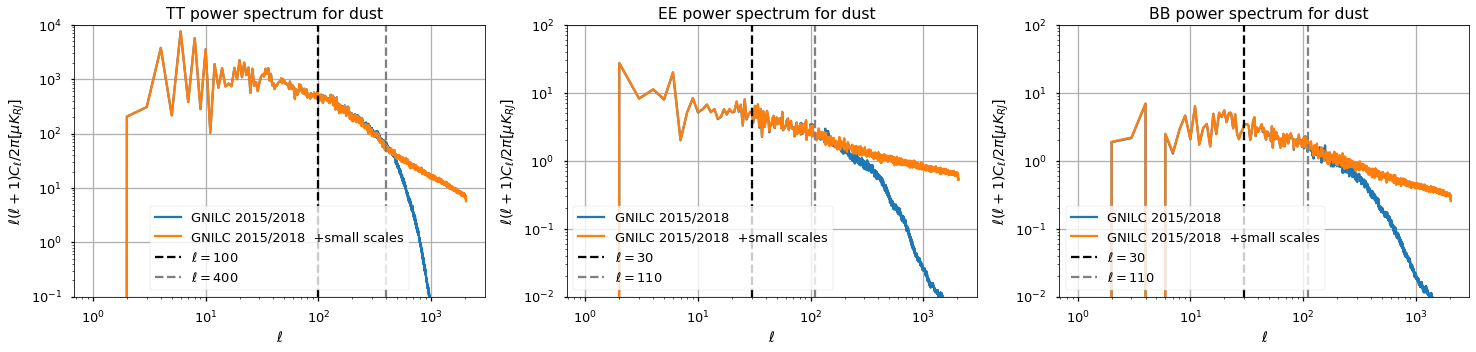

In [51]:
plt.figure(figsize=(25,5))
for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_in[pol], label="GNILC 2015/2018 ")

    plt.plot(ell, ell*(ell+1)/np.pi/2 * cl_out  [pol],label='GNILC 2015/2018  +small scales')

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust  " )
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.ylim(1e-2 if pol != "TT" else 1e-1 , 1e4 if pol == "TT" else 1e2)

### Estimate Pol. fraction distribution 

In [52]:
get_polfrac = lambda m : np.sqrt(m[1]**2 +m[2]**2 )/m[0]  

In [53]:
Pout = get_polfrac(output_map) 
Pin = get_polfrac(m_planck_varres.value  )


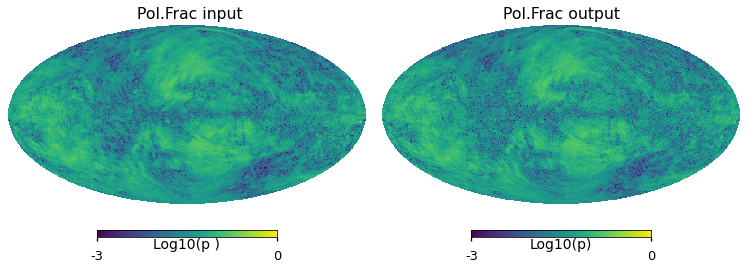

In [58]:
hp.mollview(np.log10(Pin),title=' Pol.Frac input', sub=121 , min=-3, max=0, unit='Log10(p )' )
hp.mollview(np.log10(Pout ),title='Pol.Frac output', sub=122 , min=-3, max=0 , unit='Log10(p)'  )

In [79]:
logpin = np.log10(Pin  )
logpout =np.log10(Pout )

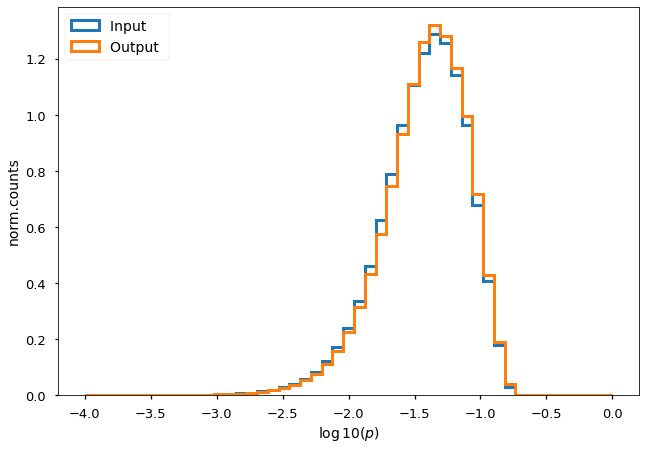

In [104]:


plt.hist(logpin ,bins=np.linspace(-4,0,50) ,  histtype='step', lw=3 , density =True, label="Input  " ) 
plt.hist(logpout ,bins=np.linspace(-4,0,50) ,  histtype='step', lw=3 , density=True, label="Output " ) 
plt.ylabel('norm.counts', fontsize=14)
plt.xlabel(r'$\log10( p )$', fontsize=14)
plt.legend( fontsize=14, loc='upper left')
